# Automatic Hyperparameter Optimization

In [1]:
%matplotlib inline
from sklearn import datasets, model_selection
import numpy as np
np.random.seed(30)
import torch
import matplotlib.pyplot as plt
plt.style.use('ggplot')

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


## Load the data

We use the **digits** dataset, which is distributed alongside scikit-learn.

In [2]:
X, Y = datasets.load_digits(return_X_y=True)

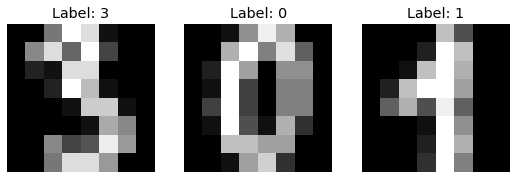

In [3]:
def plot_digit(ax, x, y):
    ax.imshow(x.reshape((8, 8)), cmap='gray')
    ax.set_title("Label: %d" % y)
    ax.set_axis_off()

# Plot three sample images from the dataset
fig, ax = plt.subplots(ncols=3, figsize=(9, 6))
plot_digit(ax[0], X[3], Y[3])
plot_digit(ax[1], X[10], Y[10])
plot_digit(ax[2], X[42], Y[42])

## Split into training and test sets

We split the data into a training set with 80% of the samples and a test set with the remaining 20%.

In [4]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(
    X, Y, test_size=0.2, random_state=10, shuffle=True)

## Data Preprocessing

As always with Falkon we must:
 1. Convert from numpy arrays to torch tensors
 2. Convert data and labels to the same data-type (in this case float32)

In [5]:
X_train = torch.from_numpy(X_train).to(dtype=torch.float32)
X_test = torch.from_numpy(X_test).to(dtype=torch.float32)
Y_train = torch.from_numpy(Y_train)
Y_test = torch.from_numpy(Y_test)

Normalizing the data is always a good idea, and it becomes even more important with automatic hyperparameter optimization. 

Here we use the global mean and standard deviation of the training set for **z-score normalization**.

In [6]:
# z-score normalization
train_mean = X_train.mean()
train_std = X_train.std()
X_train -= train_mean
X_train /= train_std
X_test -= train_mean
X_test /= train_std

Since Falkon optimizes with respect to the square loss, using ordinal labels (e.g. 1, 4, 5) is not ideal since closeness in the natural numbers is meaningless for classification.

We therefore convert the labels to a **1-hot representation**.

In [7]:
# Convert labels to 1-hot
eye = torch.eye(10, dtype=torch.float32)
Y_train = eye[Y_train]
Y_test = eye[Y_test]
print("First label vector: ", Y_train[0])

First label vector:  tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])


## Hyperparameter Optimization

The Falkon algorithm has three main kinds of hyper-parameters:
 1. The kernel parameters. Most commonly when using the Gaussian kernel these are the length-scales for each dimension in the data
 2. The amount of regularization $\lambda$ (the penalty term, which helps prevent overfitting).
 3. The Nystrom centers. These are sometimes not considered hyper parameters, and they are chosen uniformly at random from the training set. However, it is possible to find better centers!
 
In the [grid-search](falkon_cv.ipynb) notebook all three types of hyperparameters are considered, but only with a small number of options in each category.

With automatic hyperparameter optimization, which is based on a gradient descent-type procedure, we can instead define a much larger search space for the hyperparameters.

In particular, we will optimize the kernel length-scale (one for each dimension in the data), the regularization and the Nystrom centers. Optimizing the Nystrom centers is especially useful since it allows to reduce their number, thus speeding up the whole training and inference process!

In [8]:
def mclass_loss(true, pred):
    true = torch.argmax(true, dim=1)
    pred = torch.argmax(pred, dim=1)
    return torch.mean((true != pred).to(torch.float32))

Several functions and classes used for hyperparameter optimization reside in the `falkon.hopt` module.

Here we import the `NystromCompReg` class which defines the optimization objective.

In [9]:
import falkon.hopt
from falkon import FalkonOptions
from falkon.hopt.objectives import NystromCompReg

In [10]:
flk_opt = FalkonOptions(use_cpu=not torch.cuda.is_available())

We have to initialize the hyperparameters to some default values. In particular we choose some random initial points from the dataset as the initial Nystrom centers.

In [11]:
sigma_init = torch.tensor([1.0] * X_train.shape[1], dtype=torch.float32).requires_grad_()
kernel = falkon.kernels.GaussianKernel(sigma=sigma_init, opt=flk_opt)

penalty_init = torch.tensor(1e-5, dtype=torch.float32)
centers_init = X_train[np.random.choice(X_train.shape[0], size=(500, ), replace=False)].clone()

Now we initialize the loss function (`NystromCompReg`) and the optimization algorithm (Adam).

In [12]:
model = NystromCompReg(
    kernel=kernel, penalty_init=penalty_init, centers_init=centers_init,  # The initial hp values
    opt_penalty=True, opt_centers=True,  # Whether the various hps are to be optimized
    )
opt_hp = torch.optim.Adam(model.parameters(), lr=0.1)

And start training. Each iteration corresponds to a single gradient step over the whole dataset.

In [13]:
tr_loss, tr_err = [], []

for epoch in range(50):
    opt_hp.zero_grad()
    loss = model(X_train, Y_train)
    loss.backward()
    opt_hp.step()

    tr_loss.append(loss.item())
    tr_err.append(mclass_loss(Y_train, model.predict(X_train)))
    print(f"Epoch {epoch} Loss {tr_loss[-1]:.3f} Error {tr_err[-1] * 100:.2f}%")

Epoch 0 Loss 40310.387 Error 1.67%
Epoch 1 Loss 35137.203 Error 1.67%
Epoch 2 Loss 24207.420 Error 1.74%
Epoch 3 Loss 17153.834 Error 2.02%
Epoch 4 Loss 12490.971 Error 1.95%
Epoch 5 Loss 9343.500 Error 1.67%
Epoch 6 Loss 7062.557 Error 1.32%
Epoch 7 Loss 5359.402 Error 1.18%
Epoch 8 Loss 4108.987 Error 1.04%
Epoch 9 Loss 3210.683 Error 0.90%
Epoch 10 Loss 2569.709 Error 0.63%
Epoch 11 Loss 2121.547 Error 0.49%
Epoch 12 Loss 1814.989 Error 0.49%
Epoch 13 Loss 1606.087 Error 0.42%
Epoch 14 Loss 1460.298 Error 0.42%
Epoch 15 Loss 1353.231 Error 0.21%
Epoch 16 Loss 1269.496 Error 0.21%
Epoch 17 Loss 1199.922 Error 0.14%
Epoch 18 Loss 1139.733 Error 0.14%
Epoch 19 Loss 1088.957 Error 0.07%
Epoch 20 Loss 1043.391 Error 0.07%
Epoch 21 Loss 1002.747 Error 0.07%
Epoch 22 Loss 966.971 Error 0.07%
Epoch 23 Loss 935.513 Error 0.07%
Epoch 24 Loss 907.745 Error 0.07%
Epoch 25 Loss 883.216 Error 0.07%
Epoch 26 Loss 861.607 Error 0.07%
Epoch 27 Loss 842.661 Error 0.07%
Epoch 28 Loss 826.113 Error 0.0

In [14]:
# Evaluate the test error:
ts_preds = model.predict(X_test)
print(f"Test error: {mclass_loss(Y_test, ts_preds) * 100:.2f}%")

Test error: 0.83%


The optimized parameters are available as attributes of the `model` object:

In [15]:
print("Final value of lambda: %.3e" % (model.penalty))
print("Final value of sigma: %s" % (model.kernel.sigma.detach()))

Final value of lambda: 4.428e-05
Final value of sigma: tensor([2.3884, 2.6252, 2.7859, 2.7036, 2.6799, 2.7698, 2.7344, 3.0071, 2.5923,
        2.7421, 2.7629, 2.7525, 2.6989, 2.7232, 2.8216, 2.8830, 2.6465, 2.7994,
        2.7406, 2.7082, 2.8053, 2.6552, 2.7757, 2.6979, 2.3884, 2.7573, 2.7242,
        2.6681, 2.7780, 2.7649, 2.7010, 2.7274, 2.3884, 2.6608, 2.7477, 2.7604,
        2.8015, 2.7581, 2.6359, 2.3884, 2.8348, 2.7656, 2.6553, 2.6672, 2.7252,
        2.7499, 2.6721, 2.6589, 2.9603, 2.7725, 2.7143, 2.7481, 2.7307, 2.7093,
        2.7251, 2.7213, 2.6326, 2.6092, 2.7600, 2.7744, 2.7885, 2.6976, 2.6838,
        2.7062])


We can compare the obtained results with the grid-search notebook.

A grid-search with 1000 centers and 32 grid-points resulted in choosing a model with sigma=5, and lambda=1e-7.

The `NystromCompReg` objective with half the centers led to obtain a lower test error (0.83% vs. 1.11%) after 50 training epochs. However the obtained hyperparameters are quite different: lambda in particular is much higher at 1.1e-4.

This objective in particular has quite a high bias and tends to choose simple models instead of more complex ones (remember that since lambda is a regularizer, it can be seen as one possible measure of model complexity). In practice this is often not a problem, as we observed in this case.
